In [4]:
from diffusion import Diffusion
import torch
from datasets import load_dataset
import matplotlib.pyplot as plt
import random
import numpy as np

import os

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST
from torch.utils.data import DataLoader

import noise_schedulers

In [5]:
# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

SAVE_PLOT_DIR = "./plots"
if not os.path.exists(SAVE_PLOT_DIR):
    os.mkdir(SAVE_PLOT_DIR)

# Load and Visualize data


In [6]:
# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

In [7]:
fashion = False
batch_size = 16

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
diffusion = Diffusion(device=device)

In [10]:
# Loading the data and convert the images into a tensor and normalize them to [-1, 1]
transform = Compose([ToTensor(), Lambda(lambda x: (x - 0.5) * 2)])
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn(root="./datasets", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
def show_images(images, timesteps=[], fig_name=""):
    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(6, 6))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with subplots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                if len(timesteps) > 0:
                    plt.title(f"t={timesteps[idx]}")
                plt.axis("off")
                idx += 1

    if fig_name != "":
        plt.savefig(os.path.join(SAVE_PLOT_DIR, fig_name), bbox_inches="tight")
    plt.show()

In [14]:
def show_nth_batch(loader, n=1):
    for i, batch in enumerate(loader):
        if i == n:
            show_images(batch[0])
            break

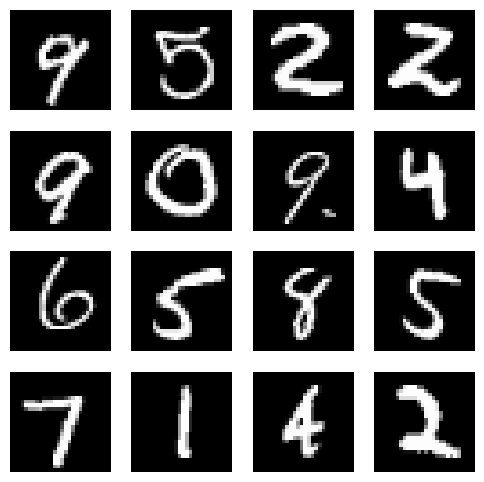

In [15]:
show_nth_batch(loader, n=4)

# Visualize a random forward diffusion process for the first batch


In [16]:
batch = next(iter(loader))[0]
batch.shape

torch.Size([16, 1, 28, 28])

In [24]:
sample_timesteps = diffusion.sample_timesteps(batch.shape[0])
sample_timesteps, sample_timesteps.shape

(tensor([759,  94, 161, 437,  84, 299, 219, 526,  83, 255, 300, 316, 405, 808,
         326, 105]),
 torch.Size([16]))

In [25]:
images_after_noise = diffusion.add_noise(batch, sample_timesteps)
images_after_noise[0].shape, images_after_noise[1].shape

(torch.Size([16, 1, 28, 28]), torch.Size([16, 1, 28, 28]))

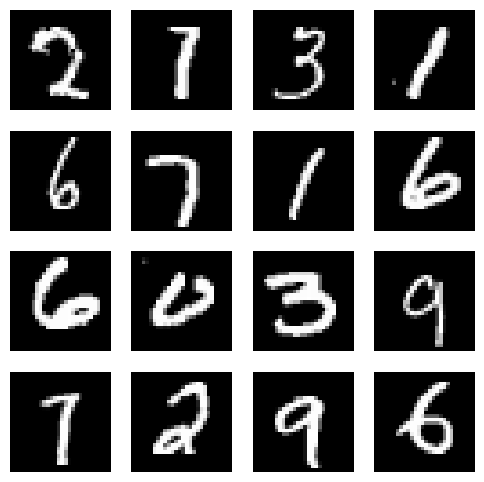

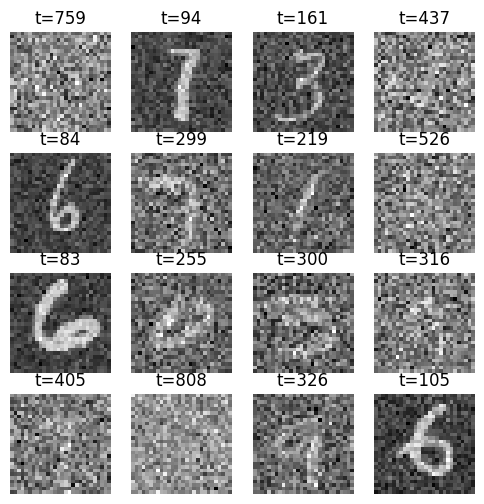

(None, None)

In [26]:
show_images(batch, fig_name="mnist_batch.png"), show_images(images_after_noise[0], sample_timesteps, fig_name="mnist_batch_with_noise.png")

In [29]:
def show_forward_process(x, schedule="linear", fig_name=""):
    model = Diffusion(schedule=schedule, device=device)

    timesteps = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]
    x_after_noise = [model.add_noise(torch.tensor(x), [t]) for t in timesteps]

    # Plot images in a row side by side
    for i, (image, t) in enumerate(zip(x_after_noise, timesteps)):
        plt.subplot(1, len(timesteps), i + 1)
        plt.imshow(image[0][0][0], cmap="gray")
        plt.title(f"t={t}", fontsize=6)
        plt.axis("off")

    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0)

    if fig_name != "":
        plt.savefig(os.path.join(SAVE_PLOT_DIR, fig_name), bbox_inches="tight")
    plt.show()

# Forward process using Linear Scheduler


/var/folders/5v/mbgy1mns1nj1h8c862ctlkrm0000gn/T/ipykernel_11930/961722153.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_after_noise = [model.add_noise(torch.tensor(x), [t]) for t in timesteps]


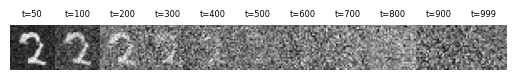

In [30]:
show_forward_process(batch[0], schedule="linear", fig_name="mnist_linear_schedule.png")

# Forward process using Cosine Scheduler


/var/folders/5v/mbgy1mns1nj1h8c862ctlkrm0000gn/T/ipykernel_11930/961722153.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_after_noise = [model.add_noise(torch.tensor(x), [t]) for t in timesteps]


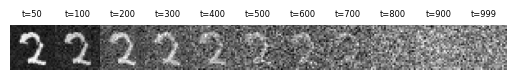

In [36]:
show_forward_process(batch[0], schedule="cosine", fig_name="mnist_cosine_schedule.png")

# Forward process using Quadratic Scheduler


/var/folders/5v/mbgy1mns1nj1h8c862ctlkrm0000gn/T/ipykernel_11930/961722153.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_after_noise = [model.add_noise(torch.tensor(x), [t]) for t in timesteps]


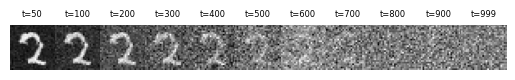

In [37]:
show_forward_process(batch[0], schedule="quadratic", fig_name="mnist_quadratic_schedule.png")

# Forward process using Sigmoid Scheduler


/var/folders/5v/mbgy1mns1nj1h8c862ctlkrm0000gn/T/ipykernel_11930/961722153.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_after_noise = [model.add_noise(torch.tensor(x), [t]) for t in timesteps]


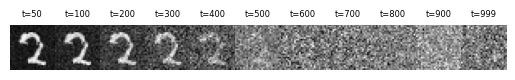

In [38]:
show_forward_process(batch[0], schedule="sigmoid", fig_name="mnist_sigmoid_schedule.png")

# Schedulers


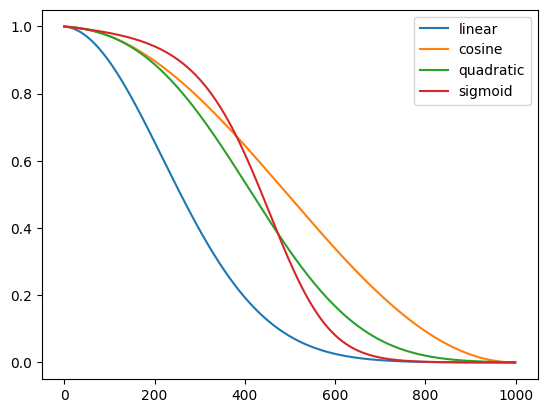

In [35]:
linear = Diffusion(schedule="linear", device=device).alpha_bar
cosine = Diffusion(schedule="cosine", device=device).alpha_bar
quadratic = Diffusion(schedule="quadratic", device=device).alpha_bar
sigmoid = Diffusion(schedule="sigmoid", device=device).alpha_bar

plt.plot(linear, label="linear")
plt.plot(cosine, label="cosine")
plt.plot(quadratic, label="quadratic")
plt.plot(sigmoid, label="sigmoid")
plt.legend()

plt.savefig(os.path.join(SAVE_PLOT_DIR, "schedules.png"), bbox_inches="tight")

plt.show()